This notebook will attempt to explore how firing up the different instruments at different times might impact the estimates of the dust flux.

In [60]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.misc import derivative

BoiseState_blue = "#0033A0"
BoiseState_orange = "#D64309"
aspect_ratio = 16./9

# These data files come from ~/research/pubs/grants/2022/MDAP-2022/Data/Met_Signal_Figure.ipynb.
pres_data_filename = "Met_Signal_Figure_pressure_data.csv"
RDS_data_filename = "Met_Signal_Figure_RDS_data.csv"
wind_data_filename = "Met_Signal_Figure_wind_data.csv"

In [74]:
# Fit functions

# See MDAP 2022 for equations

def modified_lorentzian(t, baseline, slope, t0, Delta, Gamma):
    """
    Pressure profile for a vortex

    Args:
        t (float array): time
        baseline (float): baseline against which vortex excursion
        occurs
        slope (float): slope against which excursion occurs
        t0 (float): central time for vortex excursion
        Delta (float): magnitude of excursion
        Gamma (float): full-width/half-max duration of excursion

    Returns:
        Signal for a vortex (float array)

    """
    # Equation 7 from Kahapaa+ (2016)
    return baseline + slope*(t - t0) - Delta/(((t - t0)/(Gamma/2.))**2 + 1)

def calc_wind_profile(t, t0, Delta, Gamma, U, density=0.02):
    # MKS units on everything

    Vr = np.sqrt((t - t0)/density*derivative(modified_lorentzian, t, args=(0., 0., t0, Delta, Gamma)))
    
    return np.sqrt(U**2 + Vr**2)

def wind_profile(t, t0, Vobs, U1, U2, b, Gamma_obs):

    Vr = Vobs*np.sqrt(1. + U1**2*(t - t0)**2/b**2)/(1. + (2.*(t - t0)/Gamma_obs)**2)
#   Vr_cos = np.sign(b)*Vobs/(1. + (2.*(t - t0)/Gamma_obs)**2)
    Vr_cos = Vobs/(1. + (2.*(t - t0)/Gamma_obs)**2)
    ret_val = np.sqrt(Vr**2 + 2.*U1*Vr_cos + U1**2)

    ind = t > t0

    Vr[ind] = Vobs*np.sqrt(1. + U2**2*(t[ind] - t0)**2/b**2)/(1. + (2.*(t[ind] - t0)/Gamma_obs)**2)
#   Vr_cos[ind] = np.sign(b)*Vobs/(1. + (2.*(t[ind] - t0)/Gamma_obs)**2)
    Vr_cos[ind] = Vobs/(1. + (2.*(t[ind] - t0)/Gamma_obs)**2)
    ret_val[ind] = np.sqrt(Vr[ind]**2 + 2.*U2*Vr_cos[ind] + U2**2)

    return ret_val

# def fit_wind_profile(t, wind, sigma, t0, Gamma, p0, num_gammas=3.):

#     U1 = np.nanmedian(wind[t < t0 - num_gammas*Gamma])
#     U2 = np.nanmedian(wind[t > t0 + num_gammas*Gamma])

#     popt, pcov = curve_fit(lambda t, fit_Vobs, fit_b:\
#             wind_profile(t, t0, fit_Vobs, U1, U2, fit_b, Gamma),
#             t, wind, p0=p0, sigma=sigma*np.ones_like(t))
#     uncertainties = np.sqrt(np.diag(pcov))

#     return popt, uncertainties, U1, U2

def fit_wind_profile(t, wind, sigma, t0, init_Gamma, p0, num_gammas=3.):

    U1 = np.nanmedian(wind[t < t0 - num_gammas*init_Gamma])
    U2 = np.nanmedian(wind[t > t0 + num_gammas*init_Gamma])

    popt, pcov = curve_fit(lambda t, fit_Vobs, fit_b, fit_Gamma:\
            wind_profile(t, t0, fit_Vobs, U1, U2, fit_b, fit_Gamma),
            t, wind, p0=p0, sigma=sigma*np.ones_like(t))
    uncertainties = np.sqrt(np.diag(pcov))

    return popt, uncertainties, U1, U2

def calc_lifetime(diameter, norm_factor=40.):
    # From Lorenz (2013 - https://www.sciencedirect.com/science/article/pii/S0019103513002960)
    #
    # norm_factor = 40. # seconds
    # diameter in meters

    return norm_factor*diameter**(2./3)

def calc_Delta_Pact(Vobs, Delta_Pobs, density=0.02):
    # density is in kg/m^3, so Delta Pobs must be in Pa and Vact in m/s
    return Delta_Pobs/(1. - density*Vobs**2/4./Delta_Pobs)

def calc_Vact(Vobs, Delta_Pobs, density=0.02):
    # density is in kg/m^3, so Delta Pobs must be in Pa and Vact in m/s
    return np.sqrt(Delta_Pobs/density)/np.sqrt(1. - density*Vobs**2/4./Delta_Pobs)

def calc_Dact(Delta_Pact, Delta_Pobs, Gamma_obs, U):    
    return np.sqrt(Delta_Pact/Delta_Pobs)*Gamma_obs*U

def convert_optical_depth_to_dust_loading(tau, conversion=1.4e-3):
    # Based on Eq 4 from Greeley et al. (2006)

    # conversion is in kg/m^2
    return conversion*tau

def estimate_dust_flux(Vvert, Dact, dust_loading):
    # Vvert - vertical velocity
    # Dact - dust devil diameter
    # dust loading in mass per area

    return 4.*dust_loading*Vvert/Dact
    
def estimate_dust_lofted(Vvert, Dact, dust_loading):
    # Vvert - vertical velocity
    # Dact - dust devil diameter in m
    # dust loading in mass per area

    # dust flux times dust devil area
    return estimate_dust_flux(Vvert, Dact, dust_loading)*np.pi*(Dact/2.)**2*calc_lifetime(Dact)

0.2114431270401682
0.0002960203778562355
10.500026134042333 5.9365245567158516
22.912906989339362 22.71616657357471
19.770779449896285
0.0006861325221858765
61.60576027373018


/var/folders/0p/vptds8v9203dlqkw0pv01n100000gr/T/ipykernel_1369/1527061907.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  Vr = np.sqrt((t - t0)/density*derivative(modified_lorentzian, t, args=(0., 0., t0, Delta, Gamma)))


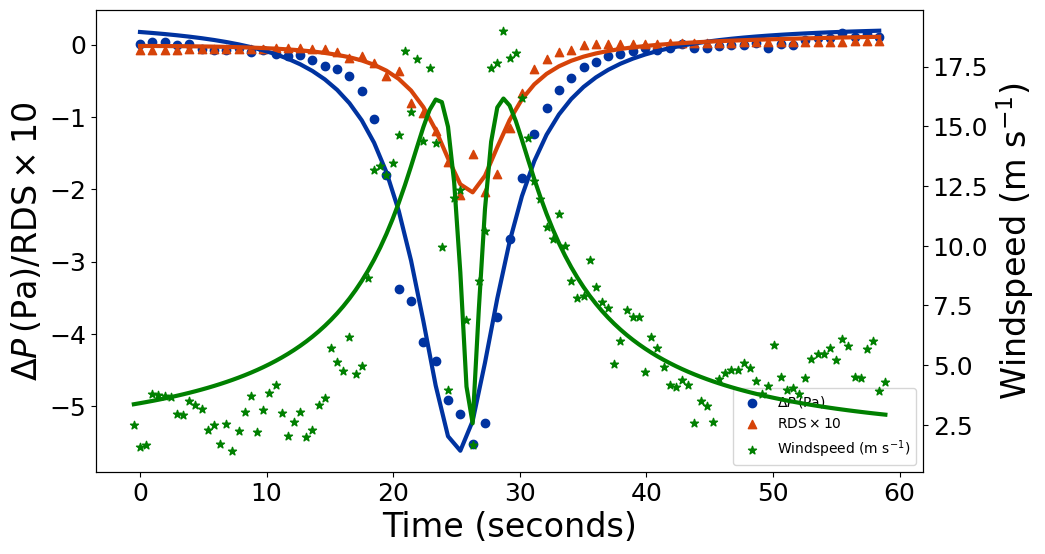

In [166]:
fig = plt.figure(figsize=(6*aspect_ratio, 6))

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

pres_data = np.genfromtxt(pres_data_filename, names=['time', 'Delta_P'], delimiter=',')
RDS_data = np.genfromtxt(RDS_data_filename, names=['time', 'RDS'], delimiter=',')
wind_data = np.genfromtxt(wind_data_filename, names=['time', 'windspeed'], delimiter=',')

# Estimate the point-to-point scatter
sigma_pres = np.median(np.abs(np.diff(pres_data['Delta_P'])))
sigma_RDS = np.median(np.abs(np.diff(RDS_data['RDS'])))
sigma_wind = np.median(np.abs(np.diff(wind_data['windspeed'])))

#### Model fits ####

# pressure
# initial guesses by eye
pres_popt, pres_pcov = curve_fit(modified_lorentzian, pres_data['time'], pres_data['Delta_P'], 
                       sigma=sigma_pres, p0=[0., 0., np.median(pres_data['time']), 5.5, 6.])
Delta_Pobs = pres_popt[3]
Gamma_obs = pres_popt[4]
# parameter uncertainties taken to be the sqrt of the diagonal of the cov matrix
pres_unc = np.sqrt(np.diag(pres_pcov))
fixed_t0 = pres_popt[2]
fixed_gamma = pres_popt[4]

ax1.scatter((pres_data['time'] - fixed_t0)/fixed_gamma, pres_data['Delta_P'], marker='o', color=BoiseState_blue, 
               label=r'$\Delta P\,\left( {\rm Pa} \right)$')
ax1.scatter((RDS_data['time'] - fixed_t0)/fixed_gamma, RDS_data['RDS']*10, marker='^', color=BoiseState_orange, 
                label=r'${\rm RDS} \times 10$')
ax1.scatter([], [], marker='*', color='green', label=r'Windspeed (${\rm m\ s^{-1}}$)')
ax2.scatter((wind_data['time'], wind_data['windspeed'], marker='*', color='green',
               label=r'Windspeed (${\rm m\ s^{-1}}$)')

ax1.plot(pres_data['time'], modified_lorentzian(pres_data['time'], *pres_popt), lw=3, color=BoiseState_blue)

# RDS
RDS_popt, RDS_pcov = curve_fit(modified_lorentzian, RDS_data['time'], RDS_data['RDS'], 
                       sigma=sigma_RDS, p0=[0., 0., np.median(pres_data['time']), 5.5, 6.])
RDS_unc = np.sqrt(np.diag(RDS_pcov))
tau = RDS_popt[3] 
print(tau)

ax1.plot(pres_data['time'], modified_lorentzian(RDS_data['time'], *RDS_popt)*10, lw=3, color=BoiseState_orange)


# Wind 
wind_popt, wind_pcov = curve_fit(calc_wind_profile, wind_data['time'], wind_data['windspeed'],
                                 p0=[fixed_t0, Delta_Pobs, Gamma_obs, np.nanmin(wind_data['windspeed'])])
U1 = wind_popt[3]
wind_unc = np.sqrt(np.diag(wind_pcov))
Vobs_unc = 1./np.sqrt(wind_popt[1]/0.02)*wind_unc[1]

ax2.plot(wind_data['time'], calc_wind_profile(wind_data['time'], *wind_popt), color='green', lw=3)

Vobs = np.sqrt(wind_popt[1]/0.02)
Delta_Pact = calc_Delta_Pact(Vobs, Delta_Pobs)
Vact = calc_Vact(Vobs, Delta_Pobs)
Dact = calc_Dact(Delta_Pact, Delta_Pobs, Gamma_obs, U1)
dust_loading = convert_optical_depth_to_dust_loading(tau)

print(dust_loading)
print(Delta_Pact, Delta_Pobs)
print(Vact, Vobs)
print(Dact)

dust_flux = estimate_dust_flux(0.5*Vact, Dact, dust_loading)
print(dust_flux)
dust_lofted = estimate_dust_lofted(0.5*Vact, Dact, dust_loading)
print(dust_lofted)

ax1.tick_params(labelsize=18)
ax1.legend(loc='lower right')
ax1.set_xlabel("Time (seconds)", fontsize=24)
ax1.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)/{\rm RDS} \times 10$', fontsize=24)
ax2.tick_params(labelsize=18, axis='y')
ax2.set_ylabel(r'Windspeed (${\rm m\ s^{-1}}$)', fontsize=24)

# fig.savefig("../figure/Fitting_Dust_Devil_Profile.jpg", dpi=300, bbox_inches='tight')

plt.show()

/var/folders/0p/vptds8v9203dlqkw0pv01n100000gr/T/ipykernel_1369/1527061907.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  Vr = np.sqrt((t - t0)/density*derivative(modified_lorentzian, t, args=(0., 0., t0, Delta, Gamma)))
/var/folders/0p/vptds8v9203dlqkw0pv01n100000gr/T/ipykernel_1369/1527061907.py:26: RuntimeWarning: invalid value encountered in sqrt
  Vr = np.sqrt((t - t0)/density*derivative(modified_lorentzian, t, args=(0., 0., t0, Delta, Gamma)))


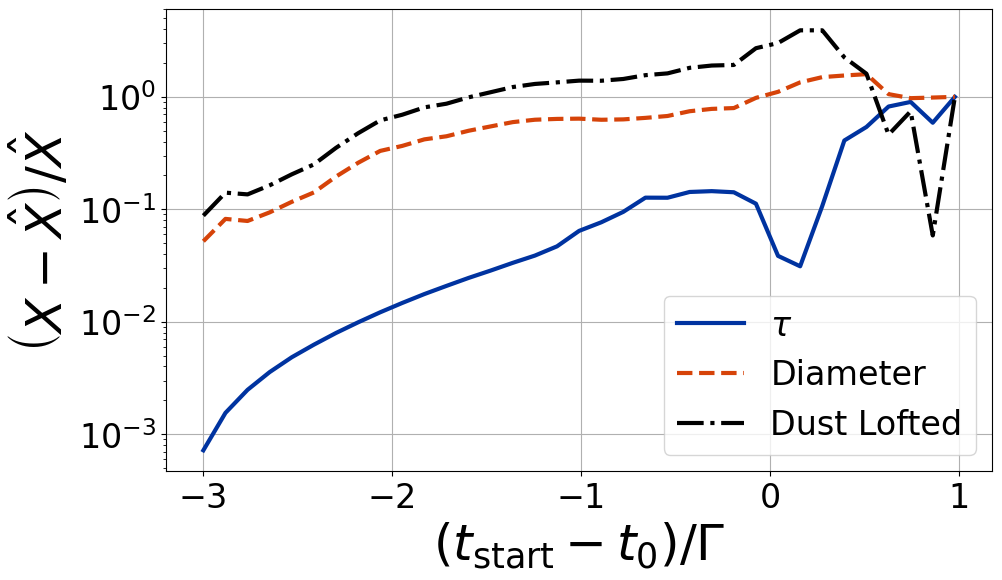

In [199]:
fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax1 = fig.add_subplot(111)
# ax2 = ax1.twinx()

# Calculate the smallest time-step worth sampling
sampling = np.max([np.median(np.diff(wind_data['time'])), np.median(np.diff(RDS_data['time']))])

# So now let's see how things change if you activate the RDS and wind sensors late
start_times = np.arange(-3.*Gamma_obs + fixed_t0, fixed_t0 + Gamma_obs, sampling)

saved_taus = np.zeros(len(start_times))
saved_taus_unc = np.zeros(len(start_times))

saved_Vobs = np.zeros(len(start_times))
saved_Vobs_unc = np.zeros(len(start_times))

saved_Dact = np.zeros(len(start_times))

saved_U1 = np.zeros(len(start_times))

saved_dust_flux = np.zeros(len(start_times))

saved_dust_lofted = np.zeros(len(start_times))

for i in range(len(start_times)):
    new_RDS_data = RDS_data[RDS_data['time'] > start_times[i]]
    new_wind_data = wind_data[wind_data['time'] > start_times[i]]

    try:        
        new_RDS_popt, new_RDS_pcov = curve_fit(modified_lorentzian, new_RDS_data['time'], new_RDS_data['RDS'], 
                               sigma=sigma_RDS, p0=[0., 0., np.median(pres_data['time']), 5.5, 6.])
        new_RDS_unc = np.sqrt(np.diag(RDS_pcov))
        saved_taus[i] = new_RDS_popt[3] 
        saved_taus_unc[i] = new_RDS_unc[3]
    
        new_wind_popt, new_wind_pcov = curve_fit(calc_wind_profile, new_wind_data['time'], new_wind_data['windspeed'],
                                     p0=[fixed_t0, Delta_Pobs, Gamma_obs, np.nanmin(wind_data['windspeed'])])
        new_wind_unc = np.sqrt(np.diag(new_wind_pcov))
        # 0.02 kg/m^3 for the air density
        saved_Vobs[i] = np.sqrt(new_wind_popt[1]/0.02)
        saved_Vobs_unc[i] = 1./np.sqrt(new_wind_popt[1]/0.02)*new_wind_unc[1]
        new_U1 = new_wind_popt[3]
        saved_U1[i] = new_U1
        
        Delta_Pact = calc_Delta_Pact(saved_Vobs[i], Delta_Pobs)
        Vact = calc_Vact(saved_Vobs[i], Delta_Pobs)
        new_Dact = calc_Dact(Delta_Pact, Delta_Pobs, Gamma_obs, new_U1)
        saved_Dact[i] = new_Dact
        
        dust_loading = convert_optical_depth_to_dust_loading(saved_taus[i])

        saved_dust_flux[i] = estimate_dust_flux(0.5*Vact, Dact, dust_loading)
        saved_dust_lofted[i] = estimate_dust_lofted(0.5*Vact, new_Dact, dust_loading)
    
    except:
        pass

# ax1.plot((start_times - fixed_t0)/Gamma_obs, np.abs(saved_taus - tau)/np.sqrt(saved_taus_unc**2 + RDS_unc[3]**2), 
#          lw=3, color=BoiseState_blue, label=r'$\tau$')

# ax1.plot((start_times - fixed_t0)/Gamma_obs, np.abs(saved_Vobs - Vobs)/np.sqrt(saved_Vobs_unc**2 + Vobs_unc**2), 
#          lw=3, color=BoiseState_orange, label=r'$V_{\rm obs}$')

# ax1.fill_between((start_times - fixed_t0)/Gamma_obs, saved_taus - saved_taus_unc, saved_taus + saved_taus_unc,
#          color=BoiseState_blue, alpha=0.5)
# ax1.axhline(tau, lw=3, ls='--', color=BoiseState_blue)

# ax1.fill_between((start_times - fixed_t0)/Gamma_obs, saved_taus - saved_taus_unc, saved_taus + saved_taus_unc,
#          color=BoiseState_blue, alpha=0.5)
# ax1.axhline(tau, lw=3, ls='--', color=BoiseState_blue)

ax1.semilogy((start_times - fixed_t0)/Gamma_obs, np.abs(saved_taus - tau)/tau, label=r'$\tau$', lw=3, color=BoiseState_blue)

# print(saved_dust_flux)

# ax1.axhline(dust_flux*1000, ls='--', lw=3, color='k')

# print(saved_Vobs)

# ax2.fill_between((start_times - fixed_t0)/Gamma_obs, saved_Vobs - saved_Vobs_unc, saved_Vobs + saved_Vobs_unc,
#          color=BoiseState_orange, alpha=0.5)
# ax2.axhline(Vobs, lw=3, ls='--', color=BoiseState_orange)

ax1.plot((start_times - fixed_t0)/Gamma_obs, np.abs(saved_Dact - Dact)/Dact, label='Diameter', lw=3, ls='--', color=BoiseState_orange)
# ax2.axhline(Dact, lw=3, ls='--', color=BoiseState_orange)

# ax2.plot((start_times - fixed_t0)/Gamma_obs, saved_U1, color=BoiseState_orange)
# ax2.axhline(U1, lw=3, ls='--', color=BoiseState_orange)

# ax1.plot((start_times - fixed_t0)/Gamma_obs, np.abs(saved_dust_flux - dust_flux)/dust_flux, label='Dust Flux', lw=3, ls='-.', color='k')
ax1.plot((start_times - fixed_t0)/Gamma_obs, np.abs(saved_dust_lofted - dust_lofted)/dust_lofted, 
         label='Dust Lofted', lw=3, ls='-.', color='k')

ax1.set_xlabel(r'$\left( t_{\rm start} - t_0 \right)/\Gamma$', fontsize=36)
ax1.set_ylabel(r'$\left( X - \hat{X} \right)/\hat{X}$', fontsize=36)
# ax1.set_ylabel(r'$\tau$', fontsize=36)
ax1.tick_params(labelsize=24)
ax1.grid(True)
ax1.legend(loc='best', fontsize=24)

# ax2.set_ylabel(r'$V_{\rm obs}\,\left( {\rm m\ s^{-1}} \right)$', fontsize=36)
# ax2.tick_params(labelsize=24)

plt.show()

# fig.savefig("../figures/Dust_Flux_Estimate_vs_Start_Time.jpg", dpi=300, bbox_inches="tight")
fig.savefig("../figures/Dust_Lofted_Estimate_vs_Start_Time.jpg", dpi=300, bbox_inches="tight")